## Challenge problem: Diffraction-limited aggregation

**Submission by ilangkay**

In [11]:
import numpy as np
import time
import matplotlib.pyplot as plt

Numpy's random-generator object facilitates the production of random points and the selection of a random element in a list (useful for choosing a direction).

In [2]:
seed = 196883
rng = np.random.default_rng(seed)

### Task 1: Generate an $n \times n$ lattice

In [3]:
def generate_lattice(n):
    '''
        Returns a square lattice with side-length n using a two-dimensional
        numpy array with all entries initially zero.
    '''
    return np.zeros((n, n))

Nonzero elements of the lattice will represent the seed, the deposited particles, and the random walker.

In [4]:
my_lattice = generate_lattice(5)
print(my_lattice)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


### Task 2: Simulate a random walker

!["Flowchart of random-walk program"](paper/resources/RW_flowchart.png)

*Explanation.* This program simulates a random walker step-by-step: it chooses a new position to go until the given number of steps is accomplished.
Lattice sites traversed by the walker have their entries incremented by an amount.
This traces the movement path.

In the following code, `tuple(walker)` allows the lattice array to correctly interpret the walker's current position as an index.

In [5]:
lattice_size = 41 # IMPORANT

def select_new_position(current_pos):
    '''
        Select a point adjacent to the walker's current position in either
        the up, down, left, and right direction for it to move to.

        Input:
            current_pos, array
        
        Output
            new_pos, numpy array
    '''
    direction = [[1, 0], [-1, 0], [0, 1], [0, -1]]

    # If the walker is on the lattice's boundary, remove directions that will cause it to go out-of-bounds.
    if current_pos[0] == 0:
        direction.remove([-1, 0])
    if current_pos[0] == lattice_size-1:
        direction.remove([1, 0])
    if current_pos[1] == 0:
        direction.remove([0, -1])
    if current_pos[1] == lattice_size-1:
        direction.remove([0, 1])
    
    return current_pos + rng.choice(direction)

The walker stopped at (31, 5)


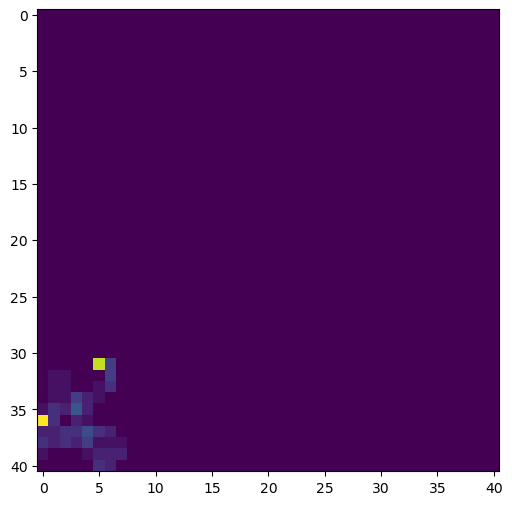

In [6]:
lattice = generate_lattice(lattice_size)

# Place a walker at a random lattice site and mark initial point
walker = rng.integers(0, lattice_size, size=2)
lattice[tuple(walker)] = 100

# Program loop
num_steps = 100
for _ in range(num_steps):
    walker = select_new_position(walker)
    lattice[tuple(walker)] += 5

# Mark final point
lattice[tuple(walker)] = 100

print(f"The walker stopped at {tuple(walker)}")

# Save final state
plt.figure(figsize=(8, 6))
plt.imshow(lattice)
# plt.imsave("Random_walk_simulation.pdf", lattice)

### Task 3: Simulate diffraction-limited aggregation

!["Flowchart of DLA program"](paper/resources/DLA_flowchart.png)

#### Walker logic

*Generation logic.*
To decrease the simulation time, I implement a suggestion in Exercise 10.13 of Newman's *Computational Physics* textbook concerned with the generation of the random walkers [1].

The idea is essentially to generate a random walker on a circle that bounds the growing cluster of deposited points and replace the walker with another if goes beyond a larger circle [2].
However, as Offringa notes, this approach slightly changes the probabilities for a particle to become deposited because certain positions can become difficult to reach [2].

In [7]:
def squared_norm(point):
    '''
        Returns the squared distance (from an origin) to a point which is represented as an array.

        Input:
            point, array
            Must have the form [x, y].
        
        Output:
            sq_norm, float
    '''
    return sum([coord**2 for coord in point])

def squared_dist_points(points):
    '''
        Returns the array of the squared distances of each point in the array-of-arrays points.

        Input:
            points, array of arrays, numpy nrray
        
        Output:
            sq_dists, numpy array
    '''
    return np.array([squared_norm(point) for point in points])

def generate_walker(r):
    '''
        Chooses a lattice point on or outside a circle of radius r+1
        for a new walker's starting position.

        Input:
            r, number
        
        Output:
            nearest_outside_grid_point, array
    '''

    # Select a random point on circle of radius r+1
    angle = rng.uniform(0, 360)
    x = (r+1) * np.cos(angle)
    y = (r+1) * np.sin(angle)

    # Gather nearby grid_points
    nearby_grid_points = np.array([
        [np.floor(x), np.floor(y)],
        [np.floor(x), np.ceil(y)],
        [np.ceil(x), np.floor(y)],
        [np.ceil(x), np.ceil(y)]
    ])

    # Take only grid points outside the cirlce
    outside_grid_points = nearby_grid_points[
        squared_dist_points(nearby_grid_points) >= (r+1)**2
    ]

    # Get the grid point nearest (x, y)
    min_dist_index = np.argmin(
        squared_dist_points(outside_grid_points - np.array([x, y]))
    )
    return outside_grid_points[min_dist_index]

The code bite
```
    outside_grid_points = nearby_grid_points[
        squared_dist_points(nearby_grid_points) >= (r+1)**2
    ]
```
takes advantage of the fact that numpy arrays can be indexed using booleans, that arrays are ordered and keep their order after a function acts on its elements.

---

*Movement and deposition logic*. 
In addition to the movement logic of the random-walk task, the walker must know when it touches any deposited point.
This is achieved by checking whether the lattice entries at the allowed possible directions are nonzero.

The function `possible_directions` starts with an array of all directions the walker can go and filters out that would cause it to go out of bounds.
Its result is then used to choose the new position the walker will go, and it is also used in checking whether the walker is adjacent to a deposit.

In [8]:
lattice_size = 201 # IMPORTANT

def possible_directions(current_pos):
    directions = [[1, 0], [-1, 0], [0, 1], [0, -1]]

    # If the walker is on the boundary, remove directions that would cause it to go out-of-bounds.
    if current_pos[0] == 0:
        directions.remove([-1, 0])
    if current_pos[0] == lattice_size - 1:
        directions.remove([1, 0])
    if current_pos[1] == 0:
        directions.remove([0, -1])
    if current_pos[1] == lattice_size - 1:
        directions.remove([0, 1])
    
    return directions

def select_new_position(current_pos):
    '''
        Selects a point adjacent to the walker's current position in either
        the up, down, left,or right direction for it to move to.
   '''
    return current_pos + rng.choice(possible_directions(current_pos))

def is_not_adjacent_to_deposit(lattice, current_pos):
    '''
        Checks if the walker is adjacent to an occupied site in the lattice,
        in either the up, down, left, or right directions.
        Returns true if that is the case; false, otherwise.
    ''' 
    for direction in possible_directions(current_pos):
        if lattice[tuple(current_pos + direction)] != 0:
            return False

    return True

*The program.*
The outer while-loop ensures that the set number of random walkers get to walk.
Then, the inner while-loop allows a random walker to roam about until either it goes too far away or it becomes attaches to a previously deposited point.

The number `color = (num_completed_walks // 100) + 1` encodes the time when a walker becomes deposited. 
Setting the lattice entry to this number will also adds colors to the final image.

The condition that `squared_norm(walker_pos - center) > r**2` checks if a newly deposited point occured beyond the bounding circle.
Then, the other condition that `r < lattice_size // 2 - 1` prevents the bounding circle from exceeding the lattice's edge as otherwise new walkers may generate out-of-bounds.
If these two are met, we may increment the radius of the bounding circle.

dla algo duration: 10.46 minpleted.


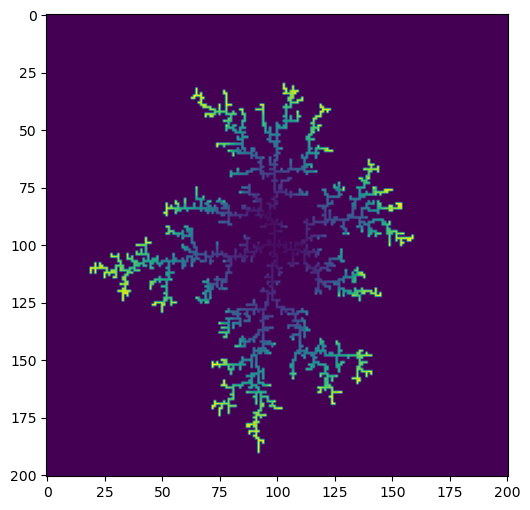

In [12]:
# Initialize lattice and plant seed at the center
# Note lattice_size is set in the previous code cell for movement logic.
center = (lattice_size - 1) // 2

lattice = generate_lattice(lattice_size)
lattice[center, center] = 1

# Program loop
num_walks = 2500
num_completed_walks = 0
r = 0

time_start = time.time()
while num_completed_walks < num_walks:
    walker_pos = np.array(generate_walker(r) + center, dtype=int)

    while is_not_adjacent_to_deposit(lattice, walker_pos):
        walker_pos = select_new_position(walker_pos)

        # Throw away walkers that stray beyond a circle with radius 2*r.
        if squared_norm(walker_pos - center) > (2*r)**2:
            break
    
    else:
        color = (num_completed_walks // 100) + 1
        lattice[tuple(walker_pos)] = color

        # Increase bounding-circle radius to account for new deposits until circle touches lattice edge.
        if squared_norm(walker_pos - center) > r**2 and r < lattice_size // 2 - 1:
            r += 1

        num_completed_walks += 1

        # Show progress
        print(f"Status: {num_completed_walks} out of {num_walks} completed.", end="\r") 

time_end = time.time()
print(f"dla algo duration: {round(abs(time_end - time_start) / 60, 2)} min")
    
# Show final state
plt.figure(figsize=(8, 6))
plt.imshow(lattice)
# plt.imsave("DLA_simulation.pdf", lattice)

# References

[1] M. E. Newman. *Computational Physics* 2nd Edition. (Createspace Independent Pub., 2013) </br>
Note that Exercise 10.13 is available online for free by the author at http://websites.umich.edu/~mejn/cp/exercises.html

[2] A. Offringa. Diffusion-limited aggregation. https://www.astro.rug.nl/~offringa/Diffusion%20Limited%20Aggregation.pdf